## 音の長さとかチェックしたい

In [3]:
!pip install torch==1.6.0
!pip install opencv-python
!pip install torchvision==0.2.2
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 748.8 MB 16 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.5 MB 29.4 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 5.6 MB/s 
     |████████████████████████████████| 52 kB 3.7 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user i

In [1]:
!pip install nnAudio

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch

from torchvision import models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as albu
from nnAudio import Spectrogram

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## util

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(100)

In [3]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train_denoise"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"

In [4]:
train = pd.read_csv(RAW_DATA / "train_tp.csv")
train['tp'] = 1
train_fp = pd.read_csv(RAW_DATA / "train_fp.csv")
train_fp['tp'] = 0
whole = pd.concat([train, train_fp])

In [5]:
wav_pathes = sorted(glob.glob(str(TRAIN_AUDIO_DIR / '*.flac')))
len(wav_pathes)

4727

In [6]:
y, sr = sf.read(wav_pathes[0])

In [7]:
from stft import Spectrogram, LogmelFilterBank
        # Spectrogram extractor
spectrogram_extractor = Spectrogram(n_fft=2048, hop_length=512, 
    win_length=2048, window='hann', center=True, pad_mode='reflect', 
    freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sr, n_fft=2048, 
    n_mels=384, fmin=40, fmax=24000, ref=1.0, amin=1e-10, top_db=None, 
    freeze_parameters=True)

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [15]:
torch_y = torch.from_numpy(y.astype(np.float32)).clone()
torch_y = torch_y.reshape(1, -1)
spectro = spectrogram_extractor(torch_y)
# batch_size x 1 x time_steps x freq_bins
mel_torch = logmel_extractor(spectro)

tensor([[[[ 1.1482e+00, -5.6912e-01, -1.2170e-01,  ..., -4.5461e-02,
            4.0077e-02, -2.7524e-02],
          [ 1.0949e+00, -5.6948e-01,  7.8373e-02,  ...,  2.2961e-02,
           -1.2796e-02,  1.9856e-03],
          [ 9.9366e-01, -5.2432e-01,  4.1070e-02,  ...,  5.0480e-03,
           -1.8836e-02,  2.5425e-02],
          ...,
          [-2.3349e-03,  1.2960e-05, -1.2076e-02,  ..., -8.5417e-03,
            2.5778e-02, -4.2275e-02],
          [-3.4739e-02, -4.6927e-02,  2.3936e-02,  ...,  6.0779e-03,
            2.2661e-02, -4.6534e-02],
          [-2.1395e-01,  2.2803e-01, -2.9152e-02,  ..., -2.8867e-03,
            2.1659e-02, -4.2707e-02]]]])


In [9]:
mel_from_torch = mel_torch.to('cpu').detach().numpy().copy()
mel_from_torch = mel_from_torch.reshape(mel_from_torch.shape[2], mel_from_torch.shape[3])
mel_from_torch.shape

(5626, 384)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


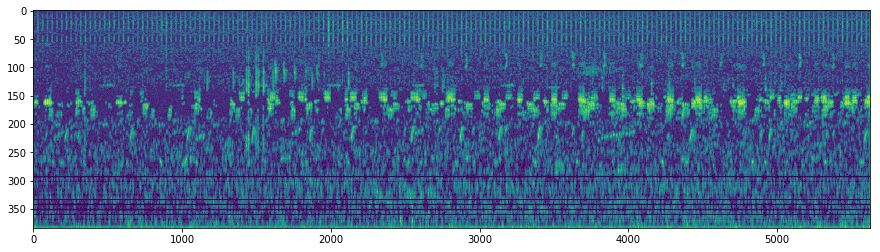

In [10]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_from_torch.T))
plt.axes().set_aspect('auto')

In [17]:
def power_to_db(input):
    """Power to db, this function is the pytorch implementation of 
    librosa.core.power_to_lb
    """
    amin=1e-10
    top_db=80.0
    ref_value = 1.0
    log_spec = 10.0 * torch.log10(torch.clamp(input, min=amin, max=np.inf))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise librosa.util.exceptions.ParameterError('top_db must be non-negative')
        log_spec = torch.clamp(log_spec, min=log_spec.max().item() - top_db, max=np.inf)

    return log_spec

In [18]:
torch_y = torch.from_numpy(y.astype(np.float32)).clone()
torch_y = torch_y.reshape(1, -1)

In [22]:
spec_layer = MelSpectrogram(sr=sr, n_fft=2048, n_mels=384, hop_length=512, fmin=40, fmax=24000)
specs = spec_layer(torch_y)
specs = power_to_db(specs)

STFT kernels created, time used = 0.1448 seconds
STFT filter created, time used = 0.0056 seconds
Mel filter created, time used = 0.0056 seconds


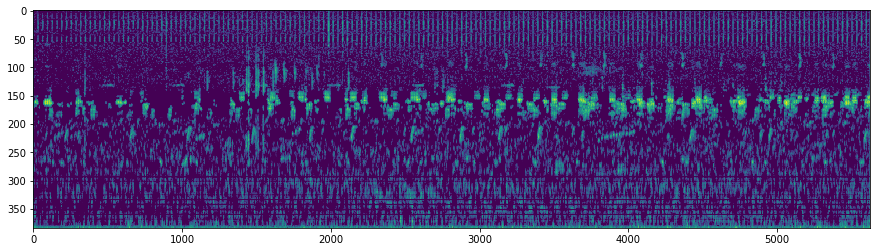

In [23]:
specs = specs.to('cpu').detach().numpy().copy()
specs = specs.reshape(specs.shape[1], specs.shape[2])
# specs = librosa.power_to_db(specs).astype(np.float32)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(specs))
plt.axes().set_aspect('auto')

In [27]:
spec_layer = Gammatonegram(sr=sr, n_fft=2048, n_bins=384, hop_length=512, fmin=40, fmax=24000)
specs = spec_layer(torch_y)
specs = power_to_db(specs)

STFT filter created, time used = 0.0267 seconds
Gammatone filter created, time used = 0.0268 seconds


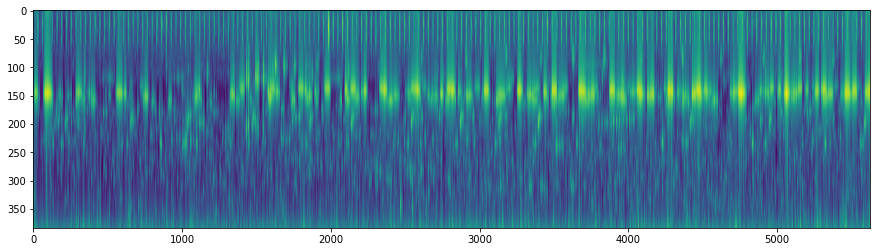

In [28]:
specs = specs.to('cpu').detach().numpy().copy()
specs = specs.reshape(specs.shape[1], specs.shape[2])
# specs = librosa.power_to_db(specs).astype(np.float32)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(specs))
plt.axes().set_aspect('auto')

In [34]:
spec_layer = CQT(sr=sr, n_bins=384, hop_length=512, fmin=40, fmax=24000)
specs = spec_layer(torch_y)
specs = power_to_db(specs)

CQT kernels created, time used = 0.0596 seconds


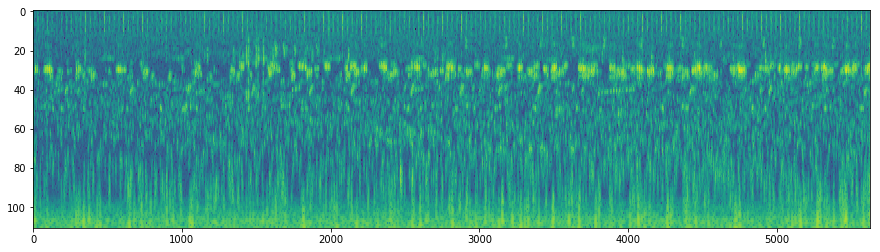

In [35]:
specs = specs.to('cpu').detach().numpy().copy()
specs = specs.reshape(specs.shape[1], specs.shape[2])
# specs = librosa.power_to_db(specs).astype(np.float32)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(specs))
plt.axes().set_aspect('auto')

In [32]:
specs.shape

(111, 5626)

In [10]:
melW = librosa.filters.mel(sr=sr, n_fft=892, n_mels=224,
            fmin=40, fmax=24000)
stft = np.abs(librosa.stft(y, n_fft=892, hop_length=245)) ** 2
mel_ = np.dot(melW, stft)

In [11]:
mel_ = librosa.power_to_db(mel_).astype(np.float32)

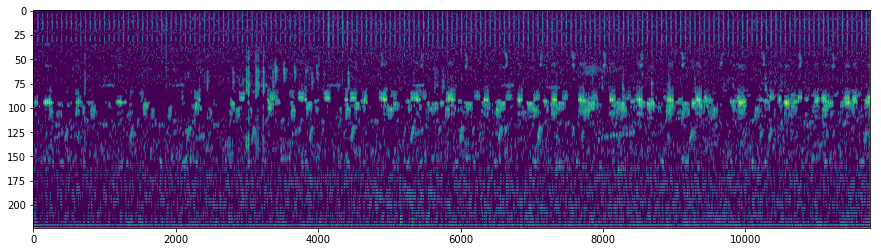

In [12]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_))
plt.axes().set_aspect('auto')

In [18]:
melW_ = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=384,
            fmin=40, fmax=24000)
stft = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) ** 2
mel_ = np.dot(melW_, stft)

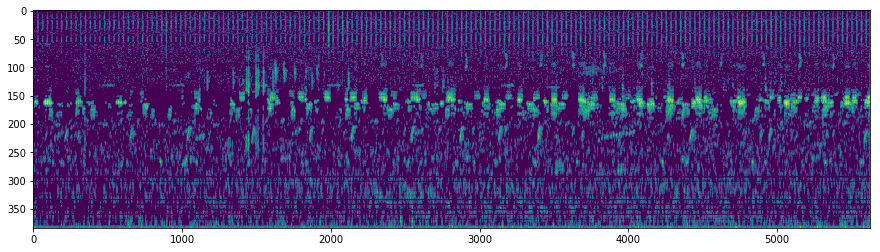

In [19]:
mel_ = librosa.power_to_db(mel_).astype(np.float32)
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(mel_))
plt.axes().set_aspect('auto')

In [20]:
melspec = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, n_mels=384,
            fmin=40, fmax=24000)
melspec = librosa.power_to_db(melspec).astype(np.float32)
melspec.shape

(384, 5626)

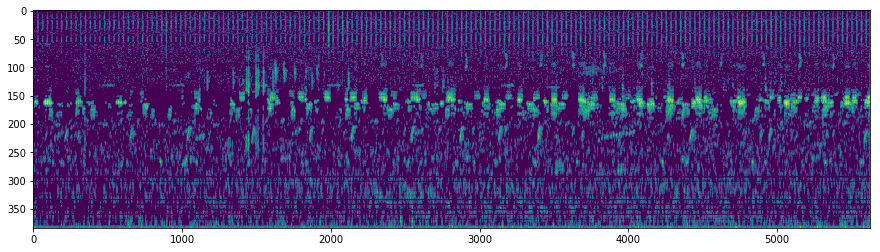

In [21]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(melspec))
plt.axes().set_aspect('auto')

In [70]:
train[train['recording_id'] == wav_num]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
3,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04


In [63]:
train['recording_id'][0]

'003bec244'

In [64]:
for path in tqdm(wav_pathes):
    if(train['recording_id'][0] in path):
        print(path)
        break

  0%|          | 0/4727 [00:00<?, ?it/s]

/home/knikaido/work/Rainforest-Connection/data/rfcx-species-audio-detection/train/003bec244.flac


In [ ]:
for i in range(len(wav_pathes)):
    wav_num = wav_pathes[0].split('/')[-1].split('.')[0]

train_csvにないwavもある！これをどうtrainにつかおうかしら．→ノートブックを確認してみる

In [78]:
np.min(whole['f_min'])

93.75

In [77]:
np.max(whole['f_max'])

13687.5

In [36]:
from gammatone.gammatone import gtgram

In [54]:
result = gtgram.gtgram(y, fs=sr, window_time=2048/sr, hop_time=512/sr, channels=128*3, f_min=40)

In [55]:
result.shape

(384, 5622)

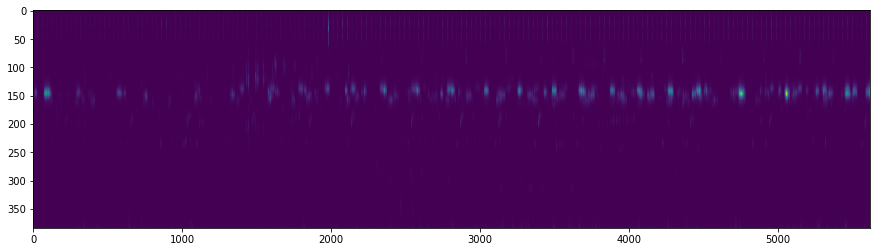

In [56]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(result))
plt.axes().set_aspect('auto')

In [53]:
result

array([[3.19143540e-04, 3.29026720e-04, 2.68986700e-04, ...,
        1.36824763e-04, 1.71331349e-04, 2.35598200e-04],
       [2.89343078e-04, 3.00770691e-04, 2.54375200e-04, ...,
        1.34270271e-04, 1.71395827e-04, 2.46582849e-04],
       [2.65912003e-04, 2.79600250e-04, 2.49064492e-04, ...,
        1.30706303e-04, 1.69069583e-04, 2.47963533e-04],
       ...,
       [1.95903909e-04, 1.15639626e-04, 5.80959445e-05, ...,
        4.35880826e-05, 7.69110428e-05, 1.18501716e-04],
       [1.64219265e-04, 9.37988541e-05, 4.83581229e-05, ...,
        3.93980275e-05, 6.92785581e-05, 1.02975511e-04],
       [1.40795409e-04, 7.89735532e-05, 4.16710571e-05, ...,
        3.51863153e-05, 6.17833300e-05, 9.02445746e-05]])